In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats

# Step 1: Load the dataset and perform initial data exploration
data = pd.read_excel('customer_churn_large_dataset.xlsx')

# Check basic statistics
print(data.describe())

# Check column names and data types
print(data.info())

# Check missing values
print(data.isnull().sum())

# Step 2: Handling missing data
# For missing data in 'Gender' and 'Location', fill with the most common value (mode).
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
data['Location'].fillna(data['Location'].mode()[0], inplace=True)

# Step 3: Handle outliers
# Identify and handle outliers using the IQR method for numerical columns
numerical_cols = ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# Step 4: Prepare the data for machine learning
# Encode categorical variables (Gender and Location) using one-hot encoding
data = pd.get_dummies(data, columns=['Gender', 'Location'], drop_first=True)

# Split the data into features (X) and target (y) for machine learning
X = data.drop(columns=['CustomerID', 'Name', 'Churn'])
y = data['Churn']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


          CustomerID            Age  Subscription_Length_Months  \
count  100000.000000  100000.000000               100000.000000   
mean    50000.500000      44.027020                   12.490100   
std     28867.657797      15.280283                    6.926461   
min         1.000000      18.000000                    1.000000   
25%     25000.750000      31.000000                    6.000000   
50%     50000.500000      44.000000                   12.000000   
75%     75000.250000      57.000000                   19.000000   
max    100000.000000      70.000000                   24.000000   

        Monthly_Bill  Total_Usage_GB          Churn  
count  100000.000000   100000.000000  100000.000000  
mean       65.053197      274.393650       0.497790  
std        20.230696      130.463063       0.499998  
min        30.000000       50.000000       0.000000  
25%        47.540000      161.000000       0.000000  
50%        65.010000      274.000000       0.000000  
75%        82.6400

In [4]:
# Step 4: Feature Engineering
# Generate a new feature 'Cost_Per_GB' by dividing 'Monthly_Bill' by 'Total_Usage_GB'
data['Cost_Per_GB'] = data['Monthly_Bill'] / data['Total_Usage_GB']

# Drop the original 'Monthly_Bill' and 'Total_Usage_GB' columns
data.drop(columns=['Monthly_Bill', 'Total_Usage_GB'], inplace=True)

# Step 5: Feature Scaling (Normalization)
# Standardize the numerical features using z-score scaling
numerical_cols = ['Age', 'Subscription_Length_Months', 'Cost_Per_GB']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Step 6: Prepare the data for machine learning (again, after feature engineering and scaling)
X = data.drop(columns=['CustomerID', 'Name', 'Churn'])
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, you have the dataset with feature engineering and scaling applied.
# You can proceed to build and train your machine learning model using X_train and y_train.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [6]:
# Step 5: Model Building (Random Forest Classifier)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Step 6: Model Validation and Evaluation
y_pred = rf_classifier.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate and print precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate and print recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate and print F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1:.2f}')

# Generate a classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.50
Precision: 0.50
Recall: 0.49
F1-score: 0.50
              precision    recall  f1-score   support

           0       0.51      0.51      0.51     10079
           1       0.50      0.49      0.50      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000

[[5176 4903]
 [5029 4892]]


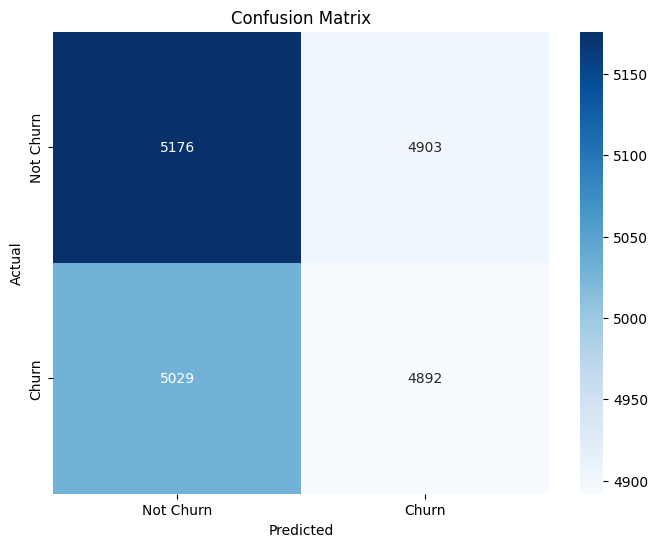

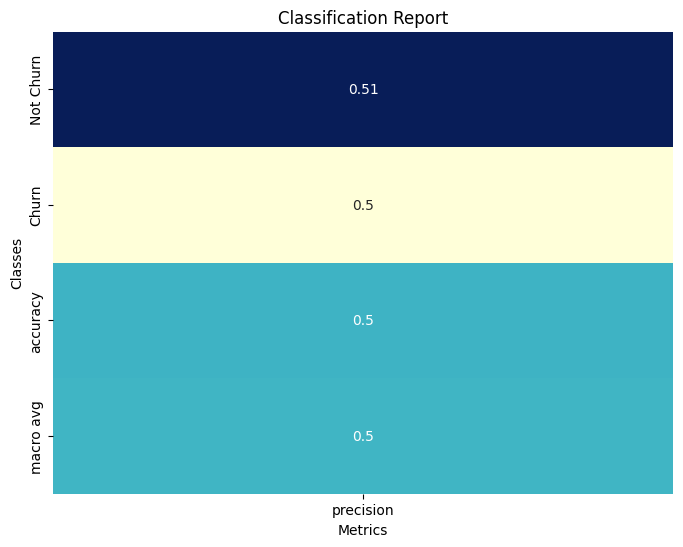

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Generate a classification report
class_report = classification_report(y_test, y_pred, target_names=['Not Churn', 'Churn'], output_dict=True)

# Create a heatmap for the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display the classification report as a heatmap
class_report_df = pd.DataFrame(class_report).transpose()
plt.figure(figsize=(8, 6))
sns.heatmap(class_report_df.iloc[:-1, :-3], annot=True, cmap='YlGnBu', cbar=False)
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report')
plt.show()


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

# Step 5: Model Optimization (Randomized Search Cross-Validation)
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Use StratifiedKFold for cross-validation (maintains class distribution)
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist, n_iter=20, cv=stratified_cv, scoring='accuracy', n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)

# the best parameters from Randomized Search
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')

# the best model
best_rf_model = random_search.best_estimator_

# Step 6: Model Evaluation (using the best model from the grid search)
y_pred = best_rf_model.predict(X_test)

# Calculate and print accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 124}
Accuracy: 0.50
Precision: 0.49
Recall: 0.42
F1-score: 0.45


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have already trained a model and made predictions (y_pred)

# Generate a classification report
class_report = classification_report(y_test, y_pred, target_names=['Not Churn', 'Churn'], output_dict=True)

# heatmap for the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# the classification report as a heatmap
class_report_df = pd.DataFrame(class_report).transpose()
plt.figure(figsize=(8, 6))
sns.heatmap(class_report_df.iloc[:-1, :-3], annot=True, cmap='YlGnBu', cbar=False)
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report')
plt.show()


NameError: ignored

In [ ]:
import joblib

# Save the model for deployment
# 'best_rf_model' is our trained model
model_filename = 'churn_prediction_model.pkl'
joblib.dump(best_rf_model, model_filename)
